# Demo of From-scratch Logistic Regression Model
This notebook serves as a demo of the from-scratch logistic regression class in __`logreg.py`__. 

The point of this notebook is not to train an accurate model, so a lot of the niceties such as data normalization, creating a validation set, feature selection/engineering etc. are ignored. We will see that the model trains and predicts well enough on a single held out set without any of these other steps. 

The data is derived from a Portugese bank's telemarketing campaign aimed at getting more term deposit subscriptions. The dependent variable we are trying to predict is a binary 'yes' or 'no' to whether or not a callee will subscribe to a term deposit.

In [1]:
import logreg
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

import time

np.random.seed(123)

In [2]:
data = pd.read_csv('../data/bank.csv', sep=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
# get targets
y = data.y.apply(lambda x: 0 if x == 'no' else 1)
data = data.drop('y', axis=1)

### Transform categorical data

In [4]:
# candidates for integer encoding (ordinal variables):
to_label = ['education', 'month', 'housing']

# candidates for one-hot encoding (nominal variables):
to_onehot = ['job', 'loan', 'marital', 'contact', 'poutcome', 'default']

# scikit-learn label encoder
le = LabelEncoder()

# get dummy and label encodings
dummies = pd.get_dummies(data[to_onehot])
labels = data[to_label].apply(le.fit_transform)

# Convert dataframe to dummy and label encodings
data[to_label] = labels
data = pd.concat([data, dummies], axis=1)
data = data.drop(to_onehot, axis=1)

### Get target and predictor variables

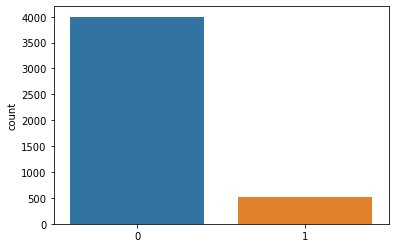

Positive class representation: 11.52 %


In [5]:
# Get predictors and targets
X = data.to_numpy()
y = y.to_numpy()

sns.countplot(x=y)
plt.show()
print(f'Positive class representation: {y.mean() * 100:.2f} %')

### Split into test/training sets
We stratify based on target to maintain distribution of samples after split. Then, we oversample the training set in order to balance the positive class during training. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# positive class is under represented, so generate synthetic training data via SMOTE
oversampler = SMOTE()
X_smote, y_smote = oversampler.fit_resample(X_train, y_train)

### Train model

Loss after 10000 epochs: 6.061110628818817
Loss after 20000 epochs: 2.6608690160265693
Loss after 30000 epochs: 2.383138369042214
Loss after 40000 epochs: 2.2580367856861114
Loss after 50000 epochs: 2.171491419147301
Loss after 60000 epochs: 2.1103535064319288
Loss after 70000 epochs: 2.06623286647642
Loss after 80000 epochs: 2.0322966549757457
Loss after 90000 epochs: 2.004428910641235
Loss after 100000 epochs: 1.9806391421459153

Total training time: 79.36162209510803 sec


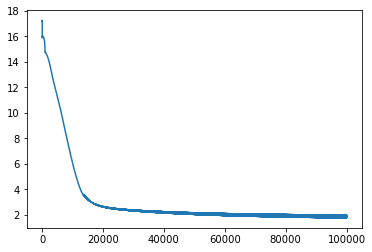

In [7]:
# create logistic regression model using all variables
regressor = logreg.BinaryLogisticRegression(X.shape[-1])

# train logistic regression model
epochs = 100000
start = time.time()
loss = regressor.train(X_smote, y_smote, epochs=epochs, lr=5e-6, print_every=10000)
end = time.time()
print(f'\nTotal training time: {end - start} sec')

# plot average loss per epoch
sns.lineplot(x=range(epochs), y=loss)
plt.show()

In [8]:
probs = regressor.infer(X_test)
predictions = [1 if p > 0.5 else 0 for p in probs]

In [9]:
# accuracy: 
(y_test == predictions).mean()

0.6397790055248619

In [10]:
fpr, tpr, thresh = roc_curve(y_test, probs, pos_label=1)
auc_score = auc(fpr, tpr)

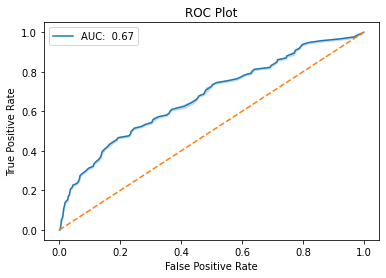

In [11]:
sns.lineplot(x=fpr, y=tpr)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([f'AUC: {auc_score: .2f}']);